# Density-Connected Datasets

Generation scripts for DENSIRED scripts.

This is the script that we used to generate all densired-datasets which are stored in densired.npz and densired_soft.npz in the datasets folder.

Since densired requires `numpy>=2.0` while other packages rely on `numpy<2.0` one needs a dedicated environment with the package `densired` installed.

In order to run this script, please install the dedicated environment by running:

`conda env create -f environment_densired.yml`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import corc

In [29]:
import densired
import numpy as np
import sklearn.preprocessing
import time
import matplotlib.pyplot as plt
import corc.visualization


In [4]:
# note that the data was generated without fixing the seed. 
# So the created dataset will look slightly different.

funky_shapes = dict()
for dim in [8,16,32,64]:
    skeleton = densired.datagen.densityDataGen(
        dim=dim,
        radius=5,
        clunum=6,
        core_num=200,
        min_dist=0.7,
        dens_factors=True,
        step_spread=0.3,
        # ratio_noise=0.1,
        ratio_con=0.01,
        seed=42
    )
    points = skeleton.generate_data(data_num=10000)
    funky_shapes[dim] = points
        
with open('densired.npz', 'wb') as f:
    np.savez(f, d8=funky_shapes[8], d16=funky_shapes[16], d32=funky_shapes[32], d64=funky_shapes[64])

In [5]:
# note that the data was generated without fixing the seed. 
# So the created dataset will look slightly different.

funky_shapes = dict()
for dim in [8,16,32,64]:
    skeleton = densired.datagen.densityDataGen(
        dim=dim,
        radius=5,
        clunum=6,
        core_num=200,
        min_dist=1.2,
        dens_factors=True,
        step_spread=0.3,
        # ratio_noise=0.1,
        ratio_con=0.01,
        distribution="studentt",
        con_distribution=4,
        seed=42
    )
    points = skeleton.generate_data(data_num=10000)
    funky_shapes[dim] = points
        
with open('densired_soft.npz', 'wb') as f:
    np.savez(f, d8=funky_shapes[8], d16=funky_shapes[16], d32=funky_shapes[32], d64=funky_shapes[64])

## Additional code to check whether the created dataset is linearly separable

In [33]:
with open('densired_soft.npz', 'rb') as f:
    data = np.load(f)

    X = X_data = data['d8'][:, :-1] # or d16, d32, d64
    y = y_data = data['d8'][:, -1] # or d16, d32, d64

Accuracy: 0.9425


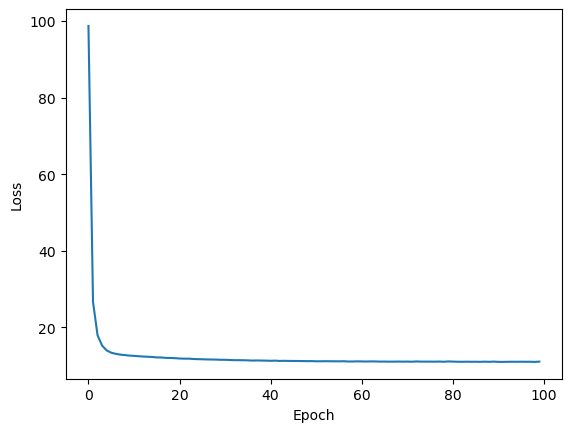

In [ ]:
import torch
import sklearn.model_selection

# constants
noise = True
dim = X.shape[1]
classes = int(np.max(y))+1 
if noise:
    classes += 1 # for the noise class


# data loading
if noise:
    y += 1# shift to avoid -1 for the noise points

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64) 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# model = torch.nn.Sequential(
#     torch.nn.Linear(dim, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, classes),
# )

model = torch.nn.Linear(dim, classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100

# train model
losses = list()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x,y in train_loader:
        starttime = time.time()
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    losses.append(epoch_loss / len(train_loader))

# check accuracy
model.eval()
total = 0
correct = 0
for x,y in test_loader:
    y_pred = model(x)
    _, y_pred = torch.max(y_pred, 1)
    total += y.size(0)
    correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f'Accuracy: {accuracy}')

# plot training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

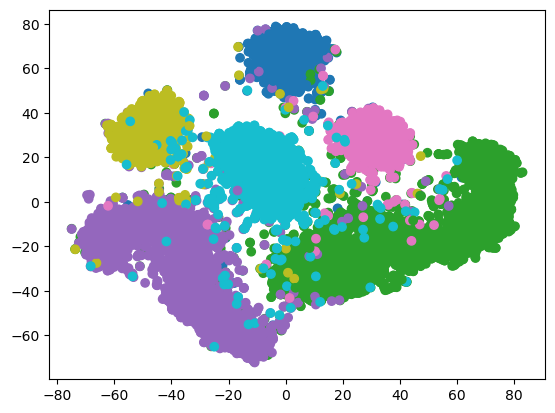

In [34]:
# plot sklearn tsne of the dataset
tsne = sklearn.manifold.TSNE()
X_embedded = tsne.fit_transform(X_data)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_data, cmap='tab10')
plt.show()